# Assignment 1: Dynamic Time Warping

---

## Task 4) Isolated Word Recognition

Due to the relatively large sample number (e.g. 8kHz), performing [DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) on the raw audio signal is not advised (feel free to try!).
A better solution is to compute a set of features; here we will extract [mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) over windows of 25ms length, shifted by 10ms.
Recommended implementation is [librosa](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html).

### Data

Download Zohar Jackson's [free spoken digit dataset](https://github.com/Jakobovski/free-spoken-digit-dataset).
There's no need to clone, feel free to use a revision, like [v1.0.10](https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/tags/v1.0.10.tar.gz).
File naming convention is trivial (`{digitLabel}_{speakerName}_{index}.wav`); let's restrict to two speakers, eg. `jackson` and `george`.

### Dynamic Time Warping

[DTW](https://en.wikipedia.org/wiki/Dynamic_time_warping) is closely related to [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) and [Needleman-Wunsch algorithm](https://en.wikipedia.org/wiki/Needleman–Wunsch_algorithm).
The main rationale behind DTW is that the two sequences are can be aligned but their speed and exact realization may very.
In consequence, cost is not dependent on an edit operation but on a difference in observations.

---

### Preparation

In [23]:
import os
import numpy as np
import librosa as lr
from typing import List, Tuple, TypedDict

In [24]:
### TODO: Read in files, compute MFCC, and organize
### Notice: You can restrict the number to a few files for each speaker-digit

class Audio(TypedDict):
    digitLabel: int
    speakerName: str
    index: int
    mfccs: List[Tuple[float]]

audios: List[Audio] = []

speakers = ["george", "jackson", "yweweler"]

### YOUR CODE HERE
n = 5
recordings_path = "C:\\Users\\Felix\\PythonProjects\\seqlrn_assignments\\1-dynamic-programming\\data\\free-spoken-digit-dataset-1.0.10\\recordings"

for recording_name in os.listdir(recordings_path):
    print(f"Checking recording: {recording_name}")
    if any(speaker in recording_name for speaker in speakers):
        recording_infos = recording_name.split(".")[0].split("_")
        y, sr = lr.load(os.path.join(recordings_path, recording_name), sr=None)
        mfccs = lr.feature.mfcc(y=y, 
                                sr=sr, 
                                n_mfcc=13,
                                n_fft=int(0.025 * sr),
                                hop_length=int(0.010 * sr))

        audios.append(Audio(digitLabel=recording_infos[0],
                            speakerName=recording_infos[1],
                            index=recording_infos[2],
                            mfccs=[tuple(frame) for frame in mfccs.T]))

organised_audios = {
    speaker: {
        str(i): list() for i in range(0, 10)
    } for speaker in speakers
}

for a in audios:
    if len(organised_audios[a["speakerName"]][a["digitLabel"]]) <= n:
        organised_audios[a["speakerName"]][a["digitLabel"]].append(a)

### END YOUR CODE

Checking recording: 0_george_0.wav
Checking recording: 0_george_1.wav
Checking recording: 0_george_10.wav
Checking recording: 0_george_11.wav
Checking recording: 0_george_12.wav
Checking recording: 0_george_13.wav
Checking recording: 0_george_14.wav
Checking recording: 0_george_15.wav
Checking recording: 0_george_16.wav
Checking recording: 0_george_17.wav
Checking recording: 0_george_18.wav
Checking recording: 0_george_19.wav
Checking recording: 0_george_2.wav
Checking recording: 0_george_20.wav
Checking recording: 0_george_21.wav
Checking recording: 0_george_22.wav
Checking recording: 0_george_23.wav
Checking recording: 0_george_24.wav
Checking recording: 0_george_25.wav
Checking recording: 0_george_26.wav
Checking recording: 0_george_27.wav
Checking recording: 0_george_28.wav
Checking recording: 0_george_29.wav
Checking recording: 0_george_3.wav
Checking recording: 0_george_30.wav
Checking recording: 0_george_31.wav
Checking recording: 0_george_32.wav
Checking recording: 0_george_33.

c:\anaconda3\envs\seqlrn\Lib\site-packages\librosa\feature\spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Checking recording: 1_george_45.wav
Checking recording: 1_george_46.wav
Checking recording: 1_george_47.wav
Checking recording: 1_george_48.wav
Checking recording: 1_george_49.wav
Checking recording: 1_george_5.wav
Checking recording: 1_george_6.wav
Checking recording: 1_george_7.wav
Checking recording: 1_george_8.wav
Checking recording: 1_george_9.wav
Checking recording: 1_jackson_0.wav
Checking recording: 1_jackson_1.wav
Checking recording: 1_jackson_10.wav
Checking recording: 1_jackson_11.wav
Checking recording: 1_jackson_12.wav
Checking recording: 1_jackson_13.wav
Checking recording: 1_jackson_14.wav
Checking recording: 1_jackson_15.wav
Checking recording: 1_jackson_16.wav
Checking recording: 1_jackson_17.wav
Checking recording: 1_jackson_18.wav
Checking recording: 1_jackson_19.wav
Checking recording: 1_jackson_2.wav
Checking recording: 1_jackson_20.wav
Checking recording: 1_jackson_21.wav
Checking recording: 1_jackson_22.wav
Checking recording: 1_jackson_23.wav
Checking recording:

### Implement Dynamic Time Warping

In [25]:
def dist(x: Tuple[float], y: Tuple[float]) -> float:
    """
    Compute the distance between two samples.

    Arguments:
    x: MFCCs of first sample.
    y: MFCCs of second sample.

    Returns the distance as float
    """
    ### YOUR CODE HERE

    return np.sqrt(sum((a - b) ** 2 for a, b in zip(x, y)))

    ### END YOUR CODE


def dtw(obs1: list, obs2: list, dist_fn) -> float:
    """
    Compute the dynamic time warping score between two observations.
    
    Arguments:
    obs1: List of first observations.
    obs2: List of second observations.
    dist_fn: Similarity function to use.

    Returns the score as float.
    """
    ### YOUR CODE HERE
    
    D = np.full((len(obs1) + 1, len(obs2) + 1), np.inf, dtype=float)
    D[0, 0] = 0

    for i in range(1, len(obs1) + 1):
        for j in range(1, len(obs2) + 1):
            cost = dist_fn(obs1[i-1], obs2[j-1])
            D[i, j] = cost + min(D[i-1, j],
                                 D[i, j-1],
                                 D[i-1, j-1])
            
    return D[len(obs1)][len(obs2)]

    ### END YOUR CODE

### Experiment 1: DTW scores

For each speaker and digit, select one recording as an observation (obs1) and the others as tests (obs2). How do scores change across speakers and across digits?

In [26]:
### YOUR CODE HERE

for speaker, digits in organised_audios.items():
    print(f"Recognizing speaker: {speaker}")

    for d, audios in digits.items():
        print(f"Recognizing digit: {d}")

        obs1 = audios[0]
        obs_to_check = audios[1:]
        for obs2 in obs_to_check:
            print(dtw(obs2["mfccs"], obs1["mfccs"], dist))

### END YOUR CODE

Recognizing speaker: george
Recognizing digit: 0
6294.51365852356
11468.13585281372
3920.8216857910156
4386.10213470459
4663.839353561401
Recognizing digit: 1
2655.789764404297
3048.8146362304688
3368.309564590454
3015.2137565612793
3203.011989593506
Recognizing digit: 2
7846.398986816406
2229.080307006836
2205.024923324585
2214.7889652252197
2612.6891288757324
Recognizing digit: 3
2800.8196411132812
2669.948589324951
3087.446138381958
2747.578525543213
2522.5804538726807
Recognizing digit: 4
2578.546573638916
2408.9937057495117
2986.1061782836914
2429.9473361968994
3022.0337867736816
Recognizing digit: 5
2797.3945178985596
3865.3983840942383
3454.0673809051514
3102.649881362915
4143.140602111816
Recognizing digit: 6
2508.217878341675
2727.7437591552734
3274.1247520446777
5154.848148345947
2776.717052459717
Recognizing digit: 7
2740.056921005249
2632.435670852661
2685.243688583374
4840.668603897095
3697.8639221191406
Recognizing digit: 8
2158.146026611328
2277.990245819092
2631.4670886

### Implement a DTW-based Isolated Word Recognizer

In [27]:
### TODO: Classify recording into digit label based on reference audio recordings

def recognize(obs: List[Tuple[float]], refs: List[Audio]) -> str:
    """
    Classify the input based on a reference list (train recordings).
    
    Arguments:
    obs: List of input observations (MFCCs).
    refs: List of audio items (train recordings).
    
    Returns classname where distance of observations is minumum.
    """
    ### YOUR CODE HERE
    scores = [(dtw(obs, r["mfccs"], dist), r["digitLabel"]) for r in refs]

    scores.sort(key=lambda x: x[0])
    min_score = scores[0]
    return min_score[1]
    
    ### END YOUR CODE

### Experiment 2: Speaker-Dependent IWR

Select training recordings from one speaker $S_i$ and disjoint test recordings from the same speaker $S_i$. Compute the Precision, Recall, and F1 metrics, and plot the confusion matrix.

Recognizing speaker: george
Predicted labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
True labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Precision: 1.0
Recall: 1.0
F1: 1.0
Recognizing speaker: jackson
Predicted labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '5', '8', '8', '9', '9']
True labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Precision: 0.95
Recall: 0.95
F1: 0.9500000000000001
Recognizing speaker: yweweler
Predicted labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '8', '6', '7', '7', '8', '8', '9', '9']
True labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Precision: 0.95
Recall: 0.95
F1: 0.9500000000000001


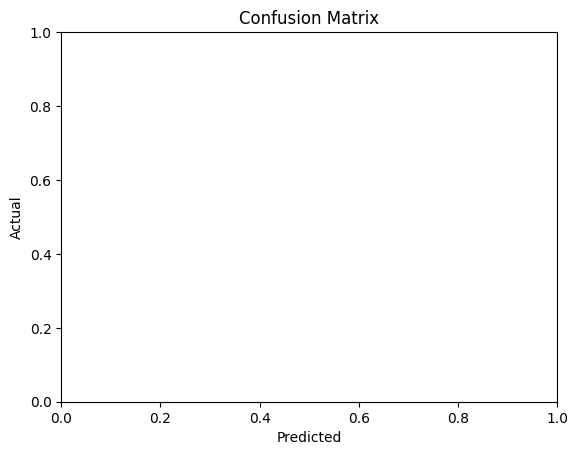

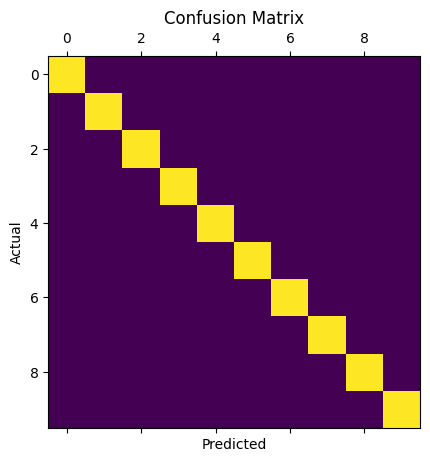

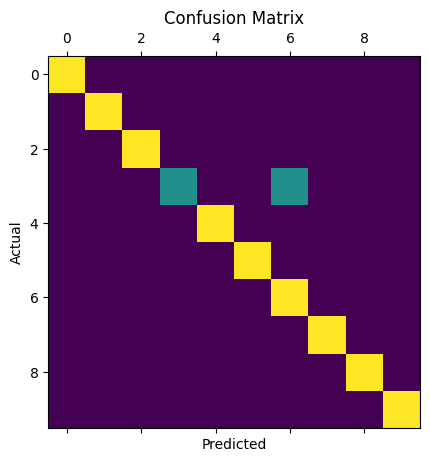

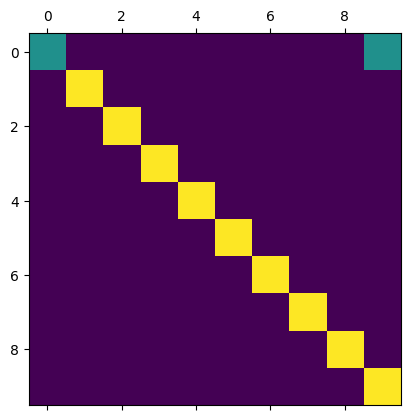

In [28]:
### YOUR CODE HERE
from typing import Dict, Set
import matplotlib.pyplot as plt

def train_test_split(digits: Dict[str, List[Audio]], 
                     train_split: float = 0.8, 
                     seed: int = 666) -> Tuple[List[Audio], List[Audio]]:
    np.random.seed(seed)
    train = []
    test = []

    for audios in digits.values():
        split_idx = int(len(audios) * train_split)
        np.random.shuffle(audios)

        train.extend(audios[:split_idx])
        test.extend(audios[split_idx:])

    return train, test

def precision(y_true, y_pred):
    tp = sum([1 for yt, yp in zip(y_true, y_pred) if yt == yp])
    return tp / len(y_pred)


def recall(y_true, y_pred):
    labels = set(y_true)
    recalls = []

    for label in labels:
        tp = sum(1 for yt, yp in zip(y_true, y_pred) if yt == yp == label)
        fn = sum(1 for yt, yp in zip(y_true, y_pred) if yt == label and yp != label)

        if tp + fn == 0:
            recalls.append(0.0)
        else:
            recalls.append(tp / (tp + fn))

    return sum(recalls) / len(recalls)


def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p + r == 0:
        return 0.0
    return 2 * (p * r) / (p + r) 


def plot_cm(y_true, y_pred):
    labels = set(y_true)
    def label_to_idx(label, labels: Set):
        return list(labels).index(label)

    CM = np.zeros(shape=(len(labels), len(labels)), dtype=int)

    for yt, yp in zip(y_true, y_pred):
        CM[int(label_to_idx(yt, labels)), int(label_to_idx(yp, labels))] += 1
    
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.matshow(CM)


for speaker, digits in organised_audios.items():
    print(f"Recognizing speaker: {speaker}")
    train, test = train_test_split(digits)
    y_pred = [recognize(obs["mfccs"], train) for obs in test]
    y_true = [obs['digitLabel'] for obs in test]
    
    print(f"Predicted labels: {y_pred}")
    print(f"True labels: {y_true}")
    print(f"Precision: {precision(y_true, y_pred)}")
    print(f"Recall: {recall(y_true, y_pred)}")
    print(f"F1: {f1_score(y_true, y_pred)}")
    plot_cm(y_true, y_pred)

### END YOUR CODE

### Experiment 3: Speaker-Independent IWR

Select training recordings from one speaker $S_i$ and test recordings from another speaker $S_j$. Compute the Precision, Recall, and F1 metrics, and plot the confusion matrix.

Recognizing speaker 'george' using 'jackson' as training data
Predicted labels: ['2', '2', '5', '5', '8', '7', '8', '8', '5', '5', '5', '5', '8', '8', '2', '7', '8', '8', '7', '7']
True labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Precision: 0.25
Recall: 0.25
F1: 0.25
Recognizing speaker 'george' using 'yweweler' as training data
Predicted labels: ['2', '2', '1', '7', '6', '6', '6', '3', '2', '2', '6', '7', '6', '6', '7', '2', '6', '6', '7', '2']
True labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Precision: 0.25
Recall: 0.25
F1: 0.25
Recognizing speaker 'jackson' using 'george' as training data
Predicted labels: ['4', '4', '1', '1', '0', '2', '2', '2', '2', '1', '5', '5', '2', '9', '4', '2', '2', '2', '1', '1']
True labels: ['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9']
Precision: 0.25
Recall: 0.25
F1: 0.25


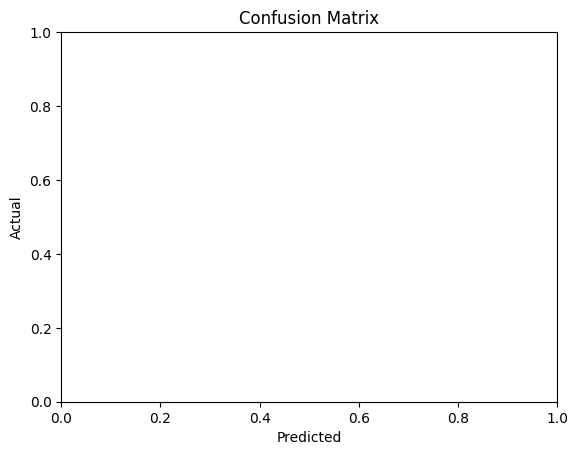

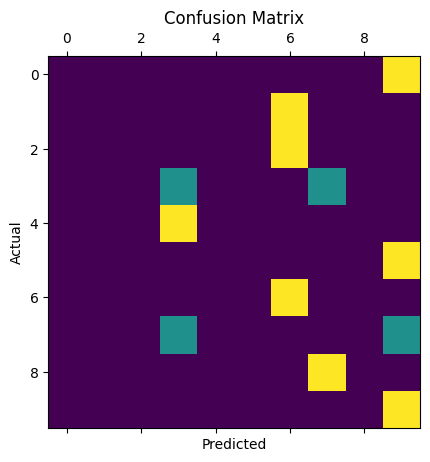

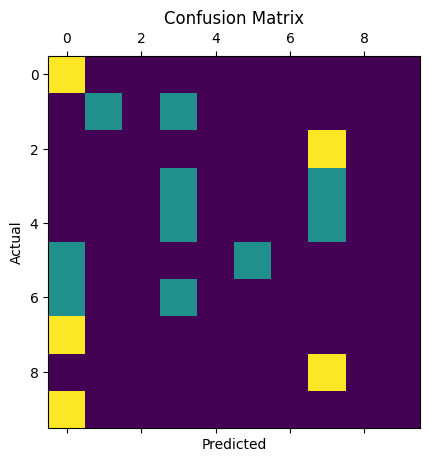

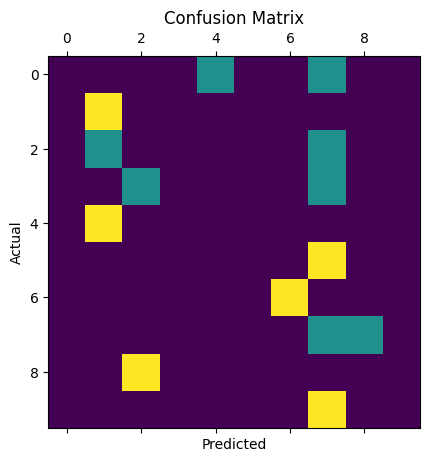

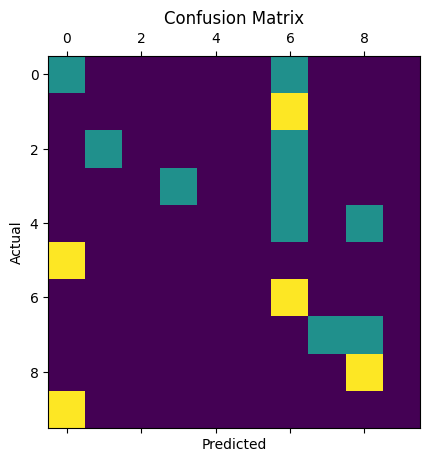

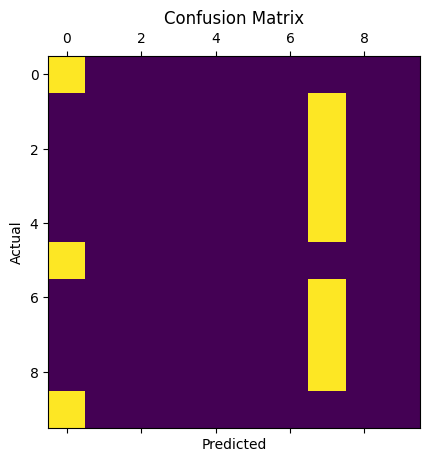

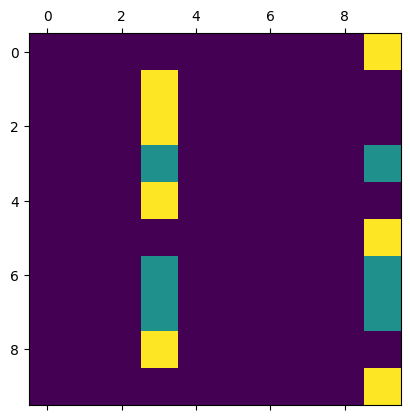

In [29]:
### YOUR CODE HERE
import itertools

for speaker1, speaker2 in itertools.permutations(organised_audios.keys(), 2):
    print(f"Recognizing speaker '{speaker1}' using '{speaker2}' as training data")

    _, test_speaker1 = train_test_split(organised_audios[speaker1])
    train_speaker2, _ = train_test_split(organised_audios[speaker2])

    y_pred = [recognize(obs["mfccs"], train_speaker2) for obs in test_speaker1]
    y_true = [obs['digitLabel'] for obs in test_speaker1]

    print(f"Predicted labels: {y_pred}")
    print(f"True labels: {y_true}")
    print(f"Precision: {precision(y_true, y_pred)}")
    print(f"Recall: {recall(y_true, y_pred)}")
    print(f"F1: {f1_score(y_true, y_pred)}")
    plot_cm(y_true, y_pred)



### END YOUR CODE

### Food for Thought

- What are inherent issues of this approach?
- How does this algorithm scale with a larger vocabulary, how can it be improved?
- How can you extend this idea to continuous speech, ie. ?